# ConvNet Example

This is a toy to help me learn pytorch

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
import time

import wandb


In [2]:
# Use CUDA
use_cuda = torch.cuda.is_available()
cuda_dev = "cuda"
device = torch.device(cuda_dev if use_cuda else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
config = {'load_workers': 20, 
          'batch_size': 200,
          'max_epochs': 100,
          'optimizer': 'SGD',
          'dataset': 'imagenette2-320'}
wandb.init(project="toy-conv-net", config=config)

W&B Run: https://app.wandb.ai/aletheap/toy-conv-net/runs/okdm5ui7

## Load our data. 

I'm using advice from https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/ about regularizing image data. 


In [4]:
transform = transforms.Compose([transforms.Resize(256),        
                                transforms.CenterCrop(224),    
                                transforms.ToTensor(),         
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                                                     std=[0.229, 0.224, 0.225])
                               ])


#datadir = "/home/apower/data/oxford-iiit-pet"
#datadir = "/mnt/data/oxford-iiit-pet"
datadir = os.path.join("/home/apower/data", wandb.config.dataset) 
traindir = os.path.join(datadir, 'train')
devdir = os.path.join(datadir, 'dev')
#testdir = os.path.join(datadir, 'test')

X_train = torchvision.datasets.ImageFolder(traindir, transform)
X_dev = torchvision.datasets.ImageFolder(devdir, transform)
#X_test = torchvision.datasets.ImageFolder(testdir, transform)

num_labels = len(X_train.classes)

#print('training_set:', len(X_train), '\ndev_set:', len(X_dev), '\ntest_set:', len(X_test), '\nlabels:', num_labels)
print('training_set:', len(X_train), '\ndev_set:', len(X_dev), '\nlabels:', num_labels)

training_set: 9469 
dev_set: 3925 
labels: 10


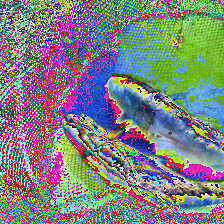

In [5]:
to_pic = torchvision.transforms.ToPILImage()
to_pic(X_train[0][0])

In [6]:
train_loader = DataLoader(X_train, batch_size=64, shuffle=True, num_workers=4)
dev_loader = DataLoader(X_dev, batch_size=1, shuffle=True)
#test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

## Let's Build the Model

In [7]:
class TestNet(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.num_labels = num_labels
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=16),
                                    nn.ReLU(),
                                    #nn.BatchNorm2d(num_features=64),
                                    nn.MaxPool2d(kernel_size=16, stride=16),
                                   )
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
                                    nn.ReLU(),
                                    #nn.BatchNorm2d(num_features=128),
                                    nn.MaxPool2d(kernel_size=4, stride=4),
                                   )
        self.fc1 = nn.Sequential(nn.Linear(in_features=512, out_features=num_labels),
                                 nn.ReLU(),
                                )                
    def forward(self, X):
        #assert X.size() == torch.Size([1, 3, 224, 224]) 
        a1 = self.layer1(X)
        #print('a1.size():', a1.size())
        a2 = self.layer2(a1)
        #print('a2.size():', a2.size())
        a2 = a2.reshape(a2.size(0), -1)
        #print('reshaped a2.size():', a2.size())
        a3 = self.fc1(a2)
        #print('a3.size():', a3.size())
        return a3
        

In [8]:

model = TestNet(num_labels=num_labels)
if use_cuda:
    model = model.to(device)
#wandb.watch(model)
model = nn.DataParallel(model)


In [9]:
#local_batch, local_labels = iter(train_loader).__next__()
#X, y = local_batch.to(device), nn.functional.one_hot(local_labels, num_classes).to(device)
#print(X.size(), y.size())
#model.forward(X)

In [10]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
def accuracy(model, loader, name):
    model = model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    #print('Accuracy of the network on the %s images: %.1f %%' % (name, accuracy))
    #wandb.log({name + '_set_accuracy': accuracy})
    return accuracy

In [12]:
def train_model(model, loader, learning_rate=0.1, losses=[10**10], max_epochs=20):
    model = model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, wandb.config.optimizer)(model.parameters(), lr=learning_rate)

    for epoch in range(max_epochs):
        batch = 0
        t0 = time.time()
        for local_batch, local_labels in loader:
            # Transfer to GPU
            X, y = local_batch.to(device), local_labels.to(device)
            y_pred = model.forward(X)
            loss = criterion(y_pred, y)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print('epoch:', epoch, 'batch:', batch, 'loss:', loss.item())
            batch += 1
        t1 = time.time()
        duration = t1-t0
        loss_num = loss.item()
        train_accuracy = accuracy(model, train_loader, 'train')
        dev_accuracy = accuracy(model, dev_loader, 'dev')
        wandb.log({'loss': loss.item(), 'secs_per_epoch': duration, 'train_accuracy': train_accuracy, 'dev_accuracy': dev_accuracy, 'relative_accuracy': dev_accuracy / train_accuracy})
        print(' ' * 4, '%.1f seconds -' % (duration), 'epoch:', epoch, 'loss:', loss_num, 'train:', train_accuracy, 'dev:', dev_accuracy, 'relative_accuracy:', dev_accuracy / train_accuracy)
        #wandb.log({'loss': loss.item(), 'secs_per_epoch': duration})
        #print(' ' * 4, '%.1f seconds -' % (duration), 'epoch:', epoch, 'loss:', loss_num)

    return model, losses

In [13]:
print('max_epochs:', wandb.config.max_epochs)

model, losses = train_model(model, train_loader, max_epochs=wandb.config.max_epochs)


max_epochs: 100
     18.9 seconds - epoch: 0 loss: 2.3025851249694824 train: 10.180589291371845 dev: 9.859872611464969 relative_accuracy: 0.9684972381531306
     12.9 seconds - epoch: 1 loss: 2.3025851249694824 train: 10.180589291371845 dev: 9.859872611464969 relative_accuracy: 0.9684972381531306
     12.8 seconds - epoch: 2 loss: 2.3025851249694824 train: 10.170028514098638 dev: 9.859872611464969 relative_accuracy: 0.9695029466039645
     12.9 seconds - epoch: 3 loss: 2.3025851249694824 train: 10.170028514098638 dev: 9.859872611464969 relative_accuracy: 0.9695029466039645
     12.8 seconds - epoch: 4 loss: 2.3025851249694824 train: 10.170028514098638 dev: 9.859872611464969 relative_accuracy: 0.9695029466039645
     13.0 seconds - epoch: 5 loss: 2.3025851249694824 train: 10.170028514098638 dev: 9.859872611464969 relative_accuracy: 0.9695029466039645
     12.9 seconds - epoch: 6 loss: 2.3025851249694824 train: 10.170028514098638 dev: 9.859872611464969 relative_accuracy: 0.96950294660396

KeyboardInterrupt: 

In [ ]:
cpu_model = model.to(torch.device('cpu'))
torch.save(cpu_model, 'toy_conv_net_model.pt')
